In [1]:
import cvxpy as cp
import numpy as np
import networkx as nx
import scipy as sp

from scipy.sparse.csgraph import floyd_warshall
from scipy.sparse import csr_matrix, csc_matrix

import os
from functools import partial
import json

import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook

from gerrychain import (
    Election,
    Graph,
    MarkovChain,
    Partition,
    accept,
    constraints,
    updaters,
)

from gerrychain.metrics import efficiency_gap, mean_median, partisan_gini
from gerrychain.proposals import recom
from gerrychain.updaters import cut_edges
from gerrychain.tree import recursive_tree_part

In [37]:
def compute_districts_distance(state, num_dists, dist_id, plan1, plan2):
    graph_path = "./" + state + ".json"
    graph = Graph.from_json(graph_path)
    
    for node in graph.nodes(data=True):
        node[1][plan1] = np.random.randint(1,num_dists+1)
        node[1][plan2] = np.random.randint(1,num_dists+1)
    
    x = [0 for i in range(len(graph.nodes()))]
    y = [0 for i in range(len(graph.nodes()))]
    
    for node in graph.nodes(data=True):
        if node[1][plan1] == dist_id:
            x[node[0]] = 1
        if node[1][plan2] == dist_id:
            y[node[0]] = 1
            
    x = np.divide(np.array(x), np.sum(x))
    x = np.reshape(x,(len(x),1))
    y = np.divide(np.array(y), np.sum(y))
    y = np.reshape(y,(len(y),1))
    
    P = nx.incidence_matrix(graph, oriented=True)
    J = cp.Variable((len(graph.edges),1))

    constraints = [P@J == x-y]

    objective = cp.Minimize(cp.sum(cp.abs(J)))

    prob = cp.Problem(objective, constraints)
    prob.solve(verbose=False, solver="ECOS")
    print("status:", prob.status)
    print("optimal value", prob.value)
#     print("optimal var", J.value)
    return P

In [40]:
%%time
P = compute_districts_distance("northcarolina", 13, 6, "plan1", "plan2")

status: optimal
optimal value 2.757201645855703
CPU times: user 432 ms, sys: 125 ms, total: 557 ms
Wall time: 647 ms


In [46]:
sparse = nx.incidence_matrix(graph, oriented=True)
type(sparse)

scipy.sparse.csc.csc_matrix

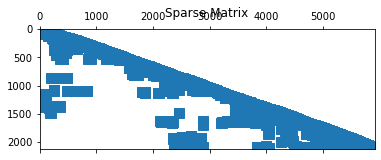

In [48]:
plt.spy(sparse)
plt.title("Sparse Matrix");